# Evaluating HRRR performance in wind gust potential

In [98]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.spatial import distance

### Loading data

These datasets are not at the same time, so only general trends can be evaluated. 

Future - Find nearest METAR station to a HRRR prediction in order to evaluate specific predictions. 

In [99]:
Met_20170701 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')
Hrrr = Dataset(  # HRRR
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/extract2Da.esrl_hrrr.201718201001300.nc')

Removing any wind gusts > 10,000 m/s, should only be NAN fill values (3.4028235e+38). 

In [100]:
met_lon = Met_20170701.variables['longitude']
met_lat = Met_20170701.variables['latitude']
met_gust = Met_20170701.variables['windGust']
met_temp = Met_20170701.variables['temperature']
met_windspeed = Met_20170701.variables['windSpeed']
met_press = Met_20170701.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, p in zip(met_gust, met_lon, met_lat, 
                                     met_temp, met_windspeed, met_press):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, p))

met_arr = np.asarray(cell)
np.nan_to_num(met_arr, False, 0)
met_arr.shape

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(4629, 6)

In [101]:
hrrr_gust = Hrrr.variables['GUST_P0_L1_GLC0']
hrrr_lat = Hrrr.variables['gridlat_0']
hrrr_lon = Hrrr.variables['gridlon_0']

hrrr_gust_flat = np.concatenate(hrrr_gust)
hrrr_lat_flat = np.concatenate(hrrr_lat)
hrrr_lon_flat = np.concatenate(hrrr_lon)

cell = []
for g, lon, lat in zip(hrrr_gust_flat, hrrr_lon_flat, hrrr_lat_flat):
    cell.append((g, lon, lat))

hrrr_arr = np.asarray(cell)
np.nan_to_num(hrrr_arr, False, 0)
hrrr_arr

array([[   7.6527605, -122.71953  ,   21.138123 ],
       [   7.6527605, -122.69286  ,   21.14511  ],
       [   7.6527605, -122.66619  ,   21.15209  ],
       ...,
       [   6.3402605,  -60.990314 ,   47.86277  ],
       [   6.2777605,  -60.953747 ,   47.85249  ],
       [   6.3402605,  -60.917194 ,   47.842194 ]], dtype=float32)

Looking for interesting features of the aggregate predictions. 

(0.0, 1000.0)

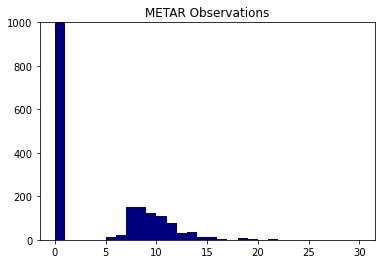

In [102]:
hist_metar = plt.hist(met_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("METAR Observations")
plt.ylim(0,1000)

(0.0, 1000000.0)

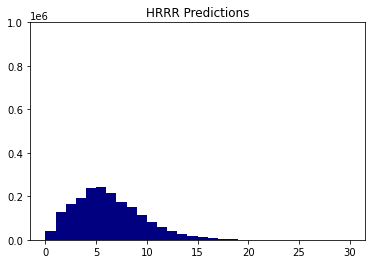

In [103]:
hist_hrrr = plt.hist(hrrr_arr[:, 0], bins=30, color='navy', range=[0,30], )
plt.title("HRRR Predictions")
plt.ylim(0,1000000)

### Comparing METAR observed wind gust to wind speed

"Time" would be a better x-axis, but I don't currently have data over time. 

In [104]:
met_arr[:,0].shape

(4629,)

Text(0, 0.5, 'Wind Gust (meter/sec)')

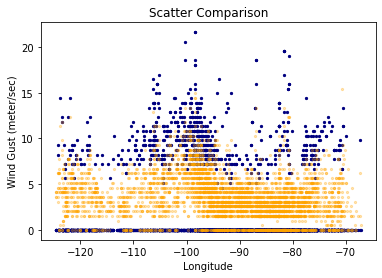

In [105]:
plt.scatter(met_arr[:,1], met_arr[:,0],  color='navy', s=5, alpha=1)
plt.scatter(met_arr[:,1], met_arr[:,4], color='orange', s=5, alpha=0.3)
plt.title("Scatter Comparison")
plt.xlabel("Longitude", size = 10)
plt.ylabel("Wind Gust (meter/sec)", size = 10)

NameError: name 'mpatches' is not defined

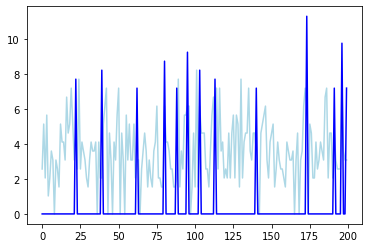

In [106]:
plt.plot(met_arr[0:200,4], color='LightBlue') #WindSpeed
plt.plot(met_arr[0:200,0], color='Blue') #Gust
wind_gust_legend = mpatches.Patch(color='Blue', label='Wind Gust')
wind_speed_legend = mpatches.Patch(color='LightBlue', label='Wind Speed')
plt.legend(handles=[wind_gust_legend,wind_speed_legend])
plt.ylabel("meter/sec", size = 10)

### Testing the process of building the closest HRRR to METAR table. 

In [107]:
(round(met_arr[1, 1], 3), round(met_arr[1, 2], 3))

(-117.78, 34.1)

### Some metars appear to be outside the US. Filter these out. 

In [108]:
def closest_node(metar, hrrrs):
    closest_index = distance.cdist([metar], hrrrs).argmin()
    return hrrrs[closest_index]

a = (hrrr_arr[:, 1:3])
lookup_dict = {}

for i in range(50,60): 
    some_pt = (round(met_arr[i, 1],3), round(met_arr[i, 2],3))
    hrrr_point = closest_node(some_pt, a)
    lookup_dict[i] = {
        "metar": some_pt,
        "hrrr": (round(hrrr_point[0],3), round(hrrr_point[1],3))
    }

lookup_dict

{50: {'metar': (-122.22, 37.73), 'hrrr': (-122.221, 37.721)},
 51: {'metar': (-121.57, 39.1), 'hrrr': (-121.554, 39.093)},
 52: {'metar': (-121.62, 39.49), 'hrrr': (-121.622, 39.498)},
 53: {'metar': (-112.02, 41.2), 'hrrr': (-112.035, 41.195)},
 54: {'metar': (-117.02, 44.02), 'hrrr': (-117.029, 44.011)},
 55: {'metar': (-118.85, 45.68), 'hrrr': (-118.837, 45.673)},
 56: {'metar': (-122.28, 47.9), 'hrrr': (-122.287, 47.906)},
 57: {'metar': (-119.51, 48.47), 'hrrr': (-119.501, 48.471)},
 58: {'metar': (-121.79, 36.94), 'hrrr': (-121.78, 36.95)},
 59: {'metar': (-122.65, 45.63), 'hrrr': (-122.653, 45.621)}}

In [109]:
lookup_dict[50]['hrrr'][0], lookup_dict[50]['hrrr'][1]

(-122.221, 37.721)

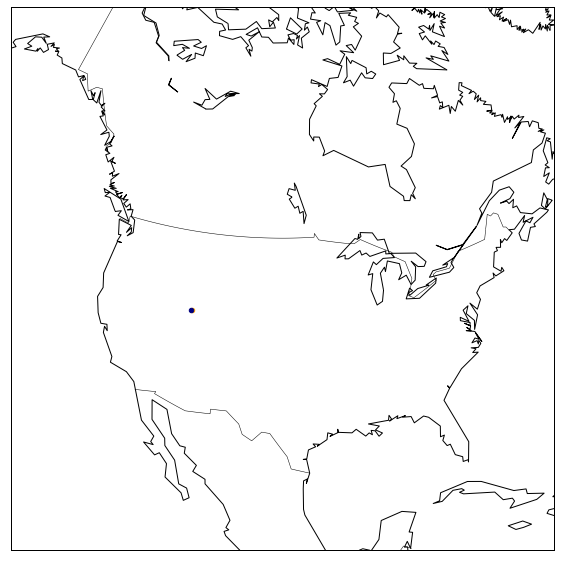

In [110]:
fig = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='c',
            width=6E6, height=6E6,
            lat_0=45, lon_0=-100, )
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
parallels = np.arange(0., 81, 10.)
meridians = np.arange(10., 351., 20.)

m.scatter(lookup_dict[53]['metar'][0], lookup_dict[53]['metar'][1], latlon=True, c='Orange', s=20)
m.scatter(lookup_dict[53]['hrrr'][0], lookup_dict[53]['hrrr'][1], latlon=True, c='Navy', s=20)

plt.show()

### Old version, with euclidean.

Measures dist as points of latitude/longitude (I believe), not kilometers. Will need some sort of conversion to find one within 3km. 

In [ ]:
lookup_dict = {}
count = 0
for i in range(10,11):
    for j in range(len(hrrr_arr)):
        dist = distance.euclidean((met_arr[i, 1], met_arr[i, 2]), (hrrr_arr[j, 1], hrrr_arr[j, 2]))
        if (dist < 5):
            count += 1
            lookup_dict[count] = {
                "metar": (met_arr[i, 1], met_arr[i, 2]),
                "hrrr": (hrrr_arr[j, 1], hrrr_arr[j, 2]),
                "distance": round(dist, 3)
            }

lookup_dict

In [ ]:
some_pt1 = [(10.76,2.9),(3.24,4.28),(7.98,1.98),(3.21,9.87)]
some_pt2 = [(11.87,6.87), (67.87,8.88), (44.44, 6.78), (9.81, 1.09), (6.91, 0.56), (8.76, 8.97), (8.21, 71.66)]

empty_dict = {}
count = 0
for i in range(len(some_pt1)):
    for j in range(len(some_pt2)):
        dist = distance.euclidean(some_pt1[i],some_pt2[j])
        if (dist < 5):
            count += 1
            empty_dict[count] = {
                "metar": some_pt1[i],
                "hrrr": some_pt2[j],
                "distance": round(dist, 3)
            }

empty_dict

### Closest HRRR to METAR. Too slow, runs for a long time, stopped after running for 15 minutes. 

In [ ]:
lookup_dict = {}
count = 0
for i in range(len(met_arr)):
    for j in range(len(hrrr_arr)):
        dist = distance.euclidean((met_arr[i, 1], met_arr[i, 2]), (hrrr_arr[j, 1], hrrr_arr[j, 2]))
        if (dist < 5):
            count += 1
            empty_dict[count] = {
                "metar": (met_arr[i, 1], met_arr[i, 2]),
                "hrrr": (hrrr_arr[j, 1], hrrr_arr[j, 2]),
                "distance": round(dist, 3)
            }

lookup_dict